In [1]:
######################################### IMPORTING PACAKGES #############################
from scipy import spatial
import pandas as pd
import os
import json
import numpy as np
import string

import warnings
warnings.filterwarnings("ignore")


import sys  
import os
from dateutil.parser import parse


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


# PDF text extraction
from pdfminer3.layout import LAParams, LTTextBox
from pdfminer3.pdfpage import PDFPage
from pdfminer3.pdfinterp import PDFResourceManager
from pdfminer3.pdfinterp import PDFPageInterpreter
from pdfminer3.converter import PDFPageAggregator
from pdfminer3.converter import TextConverter

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Others
import requests
import string
import re
from pprint import pprint
from tqdm.notebook import tqdm
import io

import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')

import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])


# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

DATA_FOLDER = "dataset/"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sieji\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sieji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
def extract_pdf(file_path):
    """
    Process raw PDF text to structured and processed PDF text to be worked on in Python.
    Parameters
    ----------
    file_path : Relative Location of File
    Return
    ------
    text : str
        processed PDF text if no error is throw
    """   

    try:
        resource_manager = PDFResourceManager()
        fake_file_handle = io.StringIO()
        codec = 'utf-8'
        laparams = LAParams()

        converter = TextConverter(resource_manager, fake_file_handle, codec=codec, laparams=laparams)
        page_interpreter = PDFPageInterpreter(resource_manager, converter)
        
        password = ""
        maxpages = 0
        caching = True
        pagenos = set()

        content = []

        with open(file_path, 'rb') as file:
            for page in PDFPage.get_pages(file,
                                        pagenos, 
                                        maxpages=maxpages,
                                        password=password,
                                        caching=True,
                                        check_extractable=False):

                page_interpreter.process_page(page)

                content.append(fake_file_handle.getvalue())

                fake_file_handle.truncate(0)
                fake_file_handle.seek(0)        

        text = '##PAGE_BREAK##'.join(content)

        # close open handles
        converter.close()
        fake_file_handle.close()
        
        return text

    except Exception as e:
        print(e)

        # close open handles
        converter.close()
        fake_file_handle.close()

        return ""

In [4]:
# nlp preprocessing
def preprocess_lines(line_input):
    """
    Helper Function to preprocess and clean sentences from raw PDF text 
    Parameters
    ----------
    line_input : str
        String that contains a sentence to be cleaned
    Return
    ------
    line : str
        Cleaned sentence
    ----------
    Sub: Substitute regular expression
    Split: Remove blank space from front and rear 
    """  
    # removing header number
    line = re.sub(r'^\s?\d+(.*)$', r'\1', line_input)
    # removing trailing spaces
    line = line.strip()
    # words may be split between lines, ensure we link them back together
    line = re.sub(r'\s?-\s?', '-', line)
    # remove space prior to punctuation
    line = re.sub(r'\s?([,:;\.])', r'\1', line)
    # ESG contains a lot of figures that are not relevant to grammatical structure
    line = re.sub(r'\d{5,}', r' ', line)
    # remove emails
    line = re.sub(r'\S*@\S*\s?', '', line)
    # remove mentions of URLs
    line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
    # remove multiple spaces
    line = re.sub(r'\s+', ' ', line)

    # # remove punctuation
    # line = re.sub(r'[,\.!?]', '', line)
    # # convert to lowercase
    # line = line.lower()

    
    # join next line with space
    line = re.sub(r' \n', ' ', line)
    line = re.sub(r'.\n', '. ', line)
    line = re.sub(r'\x0c', ' ', line)
    return line

In [5]:
def remove_non_ascii(text):
    """
    Helper Function to remove non ascii characters from text
    Printable will 
    """
    printable = set(string.printable) #Convert iterable to set
    return ''.join(filter(lambda x: x in printable, text))

def not_header(line):
    """
    Helper Function to remove headers
    Check if all the characters are in upper case
    """
    return not line.isupper()

def extract_pages_sentences(nlp, text):    
    """
    Extracting text from raw PDF text and store them by pages and senteces. Raw text is also cleand by removing junk, URLs, etc.
    Consecutive lines are also grouped into paragraphs and spacy is used to parse sentences.
    Parameters
    ----------
    nlp: spacy nlp model
        NLP model to parse sentences
    text : str
        Raw PDF text
    Return
    ------
    pages_content : list of str
        A list containing text from each page of the PDF report. Page number is the index of list + 1
    
    pages_sentences : list of list
        A list containing lists. Page number is the index of outer list + 1. Inner list contains sentences from each page
 
    """  
    MIN_WORDS_PER_PAGE = 500
    
    pages = text.split('##PAGE_BREAK##')
    #print('Number of Pages: {}'.format(len(pages)))

    lines = []
    for i in range(len(pages)):
        page_number = i + 1
        page = pages[i]
        
        # remove non ASCII characters
        text = remove_non_ascii(page)
        
        # if len(text.split(' ')) < MIN_WORDS_PER_PAGE:
        #     print(f'Skipped Page: {page_number}')
        #     continue
        
        prev = ""
        for line in text.split('\n\n'):
            # aggregate consecutive lines where text may be broken down
            # only if next line starts with a space or previous does not end with dot.
            if(line.startswith(' ') or not prev.endswith('.')):
                prev = prev + ' ' + line
            else:
                # new paragraph
                lines.append(prev)
                prev = line

        # don't forget left-over paragraph
        lines.append(prev)
        lines.append('##SAME_PAGE##')
        
    lines = '  '.join(lines).split('##SAME_PAGE##')
    
    # clean paragraphs from extra space, unwanted characters, urls, etc.
    # best effort clean up, consider a more versatile cleaner
    
    pages_content = []
    pages_sentences = []

    for line in lines[:-1]: # looping through each page
        
        line = preprocess_lines(line)       
        pages_content.append(str(line).strip())

        sentences = []
        # split paragraphs into well defined sentences using spacy
        for part in list(nlp(line).sents):
            sentences.append(str(part).strip())

        #sentences += nltk.sent_tokenize(line)
            
        # Only interested in full sentences and sentences with 10 to 100 words. --> filter out first page/content page
        sentences = [s for s in sentences if re.match('^[A-Z][^?!.]*[?.!]$', s) is not None]
        sentences = [s.replace('\n', ' ') for s in sentences]
        
        pages_sentences.append(sentences)
        
    return pages_content, pages_sentences #list, list of list where page is index of outer list

In [6]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sieji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
pages_content, pages_sentences = extract_pages_sentences(spacy.load("en_core_web_sm"),extract_pdf("dataset_jx/NYSE_RDS_2021.pdf"))

In [ ]:
pages_content

In [9]:
def lemmatization(text_list, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # lemmatize text in sentence
    """https://spacy.io/api/annotation"""
    texts_out = []
    for texts in text_list:
        texts = texts.lower()
        texts_out.append(" ".join([token.lemma_ for token in nlp(texts)]))
    return texts_out

def filter_report_highLevel(report):
    """
    Page filter to filter report for only relevant pages with decarbonisation related words.
    Two types of word filters: direct and indirect. Direct contains words that are directly related to decarbonisation while indirect contains other relevant decarbonisation information.
    
    Parameters
    ----------
    report: list of str
        A list containing text from each page of the PDF report. Page number is the index of list + 1
    Return
    ------
    filtered_report_direct : dict of {int : str}
        A dictionary that contains relevant pages obtained using direct filter. The key is the page number and value is the text on the page. 
    
    filtered_report_indirect : dict of {int : str}
        A dictionary that contains relevant pages obtained using indirect filter. The key is the page number and value is the text on the page.     
    """  
    
    # list of words used to filter
    relevant_terms_directFilter = set(["carbon","co2","environment","GHG emissions","Greenhouse Gas","carbon footprint","carbon emissions","Scope 1","Scope 2",
                               "Scope 3", "WACI","Carbon Intensity","carbon pricing","net-zero","metrics and targets","TCFD",
                                "sustainability goals","decarbonisation","climate",'energy', 'emission', 'emissions', 'renewable', 'carbon', 'fuel', 'power', 
                               'green', 'gas', 'green energy', 'sustainable', 'climate', 'sustainability', 'environmental', 'environment', 'GHG', 
                               'decarbon', 'energy consumption', 'paper consumption','water consumption', 'carbon intensity', 'waste management', 'electricity consumption', 
                                'cdp', 'global warming', 'business travel','climate solutions', 'decarbonization', 'cvar', 'climate value-at-risk','waste output'])
    relevant_terms_combinationA = ["emissions","exposure","carbon related","esg","sustainable","green","climate sensitive","impact investing", "investment framework", 'msci', 'ftse', 'responsible investing', 'responsible investment','transition']
    relevant_terms_combinationB = ["portfolio","assets","AUM","investment","financing","ratings","revenue","bond","goal","insurance", "equity", "swap", "option", "portfolio holdings", "risk management",'financial products']
    relevant_terms_combinationC = ["net zero","carbon footprint","CO2","carbon","oil","coal", "gas", "fossil fuel","green"]
    relevant_terms_combination_directFilter_lem = lemmatization(relevant_terms_directFilter)
    relevant_terms_combinationA_lem = lemmatization(relevant_terms_combinationA)
    relevant_terms_combinationB_lem = lemmatization(relevant_terms_combinationB)
    relevant_terms_combinationC_lem = lemmatization(relevant_terms_combinationC)
    
    
    filtered_report_direct = {}
    filtered_report_indirect = {}
    for i in range(len(report)):
        page = report[i]
        page_number = i + 1
        no_words = len(page.split(" "))
        
        # filter for pages that contain at least 3 words from the relevant_terms_combination_directFilter_lem list
        if sum(map(page.__contains__, relevant_terms_combination_directFilter_lem)) > 2:
            filtered_report_direct[page_number] = page
        
        # filter for pages that contain at least 1 word (relevant_terms_combinationC_lem AND relevant_terms_combinationA_lem) OR (relevant_terms_combinationC_lem AND  relevant_terms_combinationB_lem)
        elif (any(map(page.__contains__, relevant_terms_combinationA_lem)) and any(map(page.__contains__, relevant_terms_combinationC_lem))) or (any(map(page.__contains__, relevant_terms_combinationB_lem)) and any(map(page.__contains__, relevant_terms_combinationC_lem))):
            filtered_report_indirect[page_number] = page
    
    return filtered_report_direct,filtered_report_indirect

In [10]:
filtered_report_direct, filtered_report_indirect = filter_report_highLevel(pages_content)

In [20]:
##For filtered_report_direct
data_direct = list(filtered_report_direct.values())
data_direct = [d.split() for d in data_direct]

data_direct_words = list(sent_to_words(data_direct))

#remove stop words
data_direct_words = remove_stopwords(data_direct_words)
print(data_direct_words[:1][0][:30])



['report', 'shell', 'plc', 'annual', 'report', 'report', 'serves', 'annual', 'report', 'accounts', 'accordance', 'uk', 'requirements', 'year', 'ended', 'december', 'shell', 'plc', 'company', 'subsidiaries', 'collectively', 'referred', 'shell', 'report', 'presents', 'consolidated', 'financial', 'statements', 'shell', 'page']


In [ ]:
##For filtered_report_indirect
data_indirect = list(filtered_report_indirect.values())
data_indirect = [d.split() for d in data_indirect]

data_indirect_words = list(sent_to_words(data_indirect))

#remove stop words
data_indirect_words = remove_stopwords(data_indirect_words)
print(data_indirect_words)

In [22]:
#Creating dictionary
id2word_direct_words = corpora.Dictionary(data_direct_words)
id2word_indirect_words = corpora.Dictionary(data_indirect_words)

#Creating corpus
texts_direct = data_direct_words
texts_indirect = data_indirect_words
corpus_direct = [id2word_direct_words.doc2bow(text) for text in texts_direct]
corpus_indirect = [id2word_indirect_words.doc2bow(text) for text in texts_indirect]
print(corpus_direct[:1][0][:30])
print(corpus_indirect[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 2), (7, 2), (8, 2), (9, 1), (10, 1), (11, 2), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 3), (18, 1), (19, 3), (20, 1), (21, 1), (22, 2), (23, 1), (24, 3), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1)]
[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 2), (8, 1), (9, 1), (10, 2), (11, 2), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 2), (21, 1), (22, 2), (23, 1), (24, 2), (25, 1), (26, 1), (27, 2), (28, 1), (29, 2)]


In [26]:
##LDA model training for direct
from pprint import pprint

#number of topics
num_topics = 10

#building LDA model
lda_model_direct = gensim.models.LdaMulticore(corpus=corpus_direct,
                                       id2word=id2word_direct_words,
                                       num_topics=num_topics)


#Print keyword in the 10 topics
pprint(lda_model_direct.print_topics())
doc_lda_direct = lda_model_direct[corpus_direct]

[(0,
  '0.011*"shell" + 0.010*"energy" + 0.006*"report" + 0.006*"oil" + '
  '0.005*"also" + 0.005*"gas" + 0.005*"emissions" + 0.005*"risk" + '
  '0.005*"board" + 0.005*"shells"'),
 (1,
  '0.010*"shell" + 0.010*"energy" + 0.006*"shells" + 0.005*"climate" + '
  '0.005*"report" + 0.005*"financial" + 0.005*"gas" + 0.004*"transition" + '
  '0.004*"carbon" + 0.004*"also"'),
 (2,
  '0.016*"shell" + 0.009*"energy" + 0.008*"risk" + 0.007*"shells" + '
  '0.007*"climate" + 0.005*"business" + 0.005*"financial" + 0.005*"report" + '
  '0.005*"emissions" + 0.005*"change"'),
 (3,
  '0.010*"energy" + 0.010*"shell" + 0.009*"gas" + 0.008*"emissions" + '
  '0.006*"oil" + 0.006*"shells" + 0.006*"assets" + 0.006*"also" + 0.006*"risk" '
  '+ 0.005*"report"'),
 (4,
  '0.012*"shell" + 0.008*"emissions" + 0.007*"energy" + 0.006*"carbon" + '
  '0.006*"shells" + 0.006*"report" + 0.006*"products" + 0.006*"assets" + '
  '0.005*"oil" + 0.005*"gas"'),
 (5,
  '0.010*"shell" + 0.008*"gas" + 0.007*"financial" + 0.007*"s

In [46]:
# ##What is the dominant topic and its percentage contribution in each document
# ##Doing for direct_report only
# import enum


# def format_topics_sentences(ldamodel=None, corpus=corpus_direct, texts=data_direct):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     for i, row_list in enumerate(lda_model_direct[corpus_direct]):
#         row = row_list[0] if lda_model_direct.per_word_topics else row_list
#         print(row)

#         row = sorted(row, key=lambda x: (x[1]), reverse=True)

#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j==0: #==> dominant topic
#                 wp = lda_model_direct.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#     return(sent_topics_df)

# df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_direct, corpus=corpus_direct, texts=data_direct_words)


In [48]:
#Obtaining coherence score of direct text
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda_direct = CoherenceModel(model=lda_model_direct, texts=data_direct_words, dictionary=id2word_direct_words, coherence='c_v')
coherence_lda_direct = coherence_model_lda_direct.get_coherence()
print('\nCoherence Score: ', coherence_lda_direct)


Coherence Score:  0.345580902243491


Now that we have the baseline coherence score for the default LDA model, let’s perform a series of sensitivity tests to help determine the following model hyperparameters:

1. Number of Topics (K)
2. Dirichlet hyperparameter alpha: Document-Topic Density
3. Dirichlet hyperparameter beta: Word-Topic Density

We’ll perform these tests in sequence, one parameter at a time by keeping others constant and run them over the two different validation corpus sets. We’ll use C_v as our choice of metric for performance comparison

In [54]:
##supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_direct_words, dictionary=id2word_direct_words, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [59]:
#Trying to tune parameters but failed
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 6
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus_direct)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus_direct, int(num_of_docs*0.75)), 
               corpus_direct]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word_direct_words, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

 56%|█████▌    | 300/540 [1:39:21<1:19:29, 19.87s/it]


Having trained the model, the next natural step is to evaluate it. After having constructed the topics, a coherence score can be computed. The score measures the degree of semantic similarity between high scoring words in each topic. In this fashion, a coherence score can be computed for each iteration by inserting a varying number of topics.

A range of algorithms has been introduced to calculate the coherence score (C_v, C_p, C_uci, C_umass, C_npmi, C_a, …). Working with the gensim library makes computing these coherence measures for topic models fairly simple. I personally choose to implement C_v and C_umass. The coherence score for C_v ranges from 0 (complete incoherence) to 1 (complete coherence). Values above 0.5 are fairly good, according to John McLevey (source: Doing Computational Social Science: A Practical Introduction By John McLevey). On the other hand, C_umass returns negative values.

Below I simply iterate through a different number of topics and save the coherence score in a list. Afterwards, I plot using seaborn.

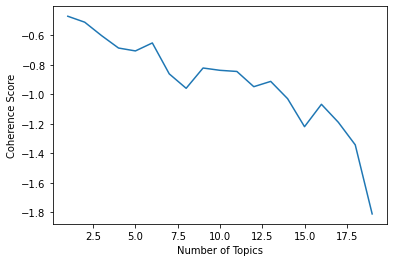

In [61]:
#calculating coherence score using C_umass
import matplotlib.pyplot as plt
topics = []
score = []
for i in range(1,20,1):
   lda_model = gensim.models.LdaMulticore(corpus=corpus_direct, id2word=id2word_direct_words, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus_direct, dictionary=id2word_direct_words, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

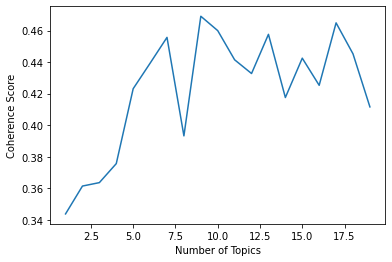

In [62]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = gensim.models.LdaMulticore(corpus=corpus_direct, id2word=id2word_direct_words, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = data_direct_words, corpus=corpus_direct, dictionary=id2word_direct_words, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

When looking at the coherence using the C_umass or C_v algorithm, the best is usually the max. I choose to go with 9 topics, even though no certain answer can be given.

In [63]:
lda_model = gensim.models.LdaMulticore(corpus=corpus_direct, id2word=id2word_direct_words, iterations=100, num_topics=9, workers = 4, passes=100)

In [65]:
##Printing out the 9 topics and related words
lda_model.print_topics(-1)

[(0,
  '0.016*"climate" + 0.016*"ac" + 0.013*"management" + 0.011*"risk" + 0.010*"financial" + 0.010*"shell" + 0.009*"risks" + 0.009*"energy" + 0.008*"reporting" + 0.008*"shells"'),
 (1,
  '0.060*"emissions" + 0.033*"energy" + 0.030*"scope" + 0.022*"ghg" + 0.020*"intensity" + 0.020*"carbon" + 0.016*"products" + 0.010*"net" + 0.010*"tonnes" + 0.010*"shell"'),
 (2,
  '0.013*"shell" + 0.012*"water" + 0.009*"company" + 0.009*"oil" + 0.008*"billion" + 0.007*"million" + 0.007*"report" + 0.007*"gas" + 0.007*"information" + 0.005*"operations"'),
 (3,
  '0.011*"assets" + 0.011*"shell" + 0.011*"oil" + 0.011*"gas" + 0.009*"shells" + 0.008*"financial" + 0.007*"energy" + 0.007*"products" + 0.006*"statements" + 0.006*"risk"'),
 (4,
  '0.021*"gas" + 0.017*"prices" + 0.014*"oil" + 0.013*"demand" + 0.011*"lng" + 0.011*"million" + 0.011*"production" + 0.009*"supply" + 0.008*"pandemic" + 0.007*"growth"'),
 (5,
  '0.013*"risk" + 0.012*"could" + 0.012*"safety" + 0.012*"risks" + 0.009*"shell" + 0.008*"envir

In [66]:
import pyLDAvis
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_direct, id2word_direct_words)
pyLDAvis.display(lda_display)

Creating model for indirect report (shell)

In [71]:
##LDA model training for indirect
from pprint import pprint

#number of topics
num_topics = 10

#building LDA model

lda_model_indirect = gensim.models.LdaMulticore(corpus=corpus_indirect,
                                       id2word=id2word_indirect_words,
                                       num_topics=num_topics)

#Print keyword in the 10 topics
pprint(lda_model_indirect.print_topics())
doc_lda_indirect = lda_model_indirect[corpus_indirect]

[(0,
  '0.014*"shell" + 0.008*"net" + 0.008*"report" + 0.008*"oil" + 0.007*"joint" '
  '+ 0.007*"financial" + 0.007*"gas" + 0.006*"ventures" + 0.005*"associates" + '
  '0.005*"total"'),
 (1,
  '0.017*"shell" + 0.006*"gas" + 0.006*"oil" + 0.006*"board" + 0.004*"cash" + '
  '0.004*"tax" + 0.004*"including" + 0.004*"also" + 0.004*"could" + '
  '0.004*"company"'),
 (2,
  '0.012*"oil" + 0.010*"shell" + 0.009*"gas" + 0.009*"net" + 0.008*"million" + '
  '0.008*"cash" + 0.007*"billion" + 0.006*"gross" + 0.006*"activities" + '
  '0.005*"earnings"'),
 (3,
  '0.014*"shell" + 0.011*"million" + 0.009*"oil" + 0.007*"earnings" + '
  '0.006*"gas" + 0.006*"interest" + 0.005*"period" + 0.005*"basis" + '
  '0.005*"report" + 0.004*"income"'),
 (4,
  '0.013*"shell" + 0.006*"gas" + 0.006*"interest" + 0.005*"oil" + 0.005*"cash" '
  '+ 0.005*"activities" + 0.004*"lng" + 0.003*"total" + 0.003*"production" + '
  '0.003*"net"'),
 (5,
  '0.021*"shell" + 0.014*"oil" + 0.011*"gas" + 0.007*"million" + '
  '0.006*"co

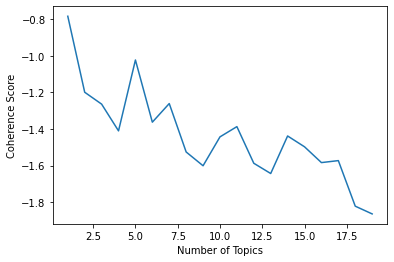

In [73]:
#calculating coherence score using C_umass for indirect
topics = []
score = []
for i in range(1,20,1):
   lda_model = gensim.models.LdaMulticore(corpus=corpus_indirect, id2word=id2word_indirect_words, num_topics=i, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus_indirect, dictionary=id2word_indirect_words, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

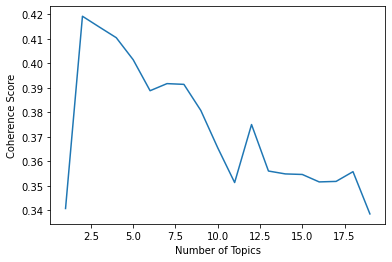

In [74]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = gensim.models.LdaMulticore(corpus=corpus_indirect, id2word=id2word_indirect_words, num_topics=i, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = data_indirect_words, corpus=corpus_indirect, dictionary=id2word_indirect_words, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

Seems like 2 is the appropriate number of topics for this indirect report, but I feel that it is too little, so we will go with the next highest value, 5

In [75]:
lda_model_indirect = gensim.models.LdaMulticore(corpus=corpus_indirect, id2word=id2word_indirect_words, num_topics=5)

In [76]:
lda_model_indirect.print_topics(-1)

[(0,
  '0.021*"shell" + 0.009*"oil" + 0.007*"earnings" + 0.007*"gas" + 0.007*"interest" + 0.006*"million" + 0.006*"net" + 0.005*"total" + 0.004*"gross" + 0.004*"report"'),
 (1,
  '0.019*"shell" + 0.010*"oil" + 0.007*"gas" + 0.006*"llc" + 0.006*"company" + 0.005*"report" + 0.005*"cash" + 0.005*"earnings" + 0.005*"million" + 0.004*"performance"'),
 (2,
  '0.015*"shell" + 0.006*"oil" + 0.006*"million" + 0.005*"tax" + 0.005*"financial" + 0.005*"earnings" + 0.005*"joint" + 0.005*"gas" + 0.004*"interest" + 0.004*"cash"'),
 (3,
  '0.010*"shell" + 0.009*"gas" + 0.008*"oil" + 0.006*"million" + 0.006*"cash" + 0.005*"risk" + 0.005*"net" + 0.005*"interest" + 0.005*"report" + 0.004*"contracts"'),
 (4,
  '0.011*"shell" + 0.008*"oil" + 0.006*"gas" + 0.005*"million" + 0.005*"earnings" + 0.004*"tax" + 0.004*"financial" + 0.003*"risk" + 0.003*"cash" + 0.003*"report"')]

In [78]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model_indirect, corpus_indirect, id2word_indirect_words)
pyLDAvis.display(lda_display)